# STEP 3: Categorize Hubble Data
## In STEP 1 we found discreet regions of redshift - surface brightness - p_features space that seemed to be correctable or uncorrectable. Since we were limited by a small-ish sample of Ferengi galaxies, the regions are discrete and noisy; here we smooth that space using the convex hull method. 

In [1]:
#Sept 8 2015
#This code is to examine the ferengi data to see whether a smoothing function can be applied to determine
# the 'correctable' regions of p_features, z, and surface brightness space. 
%matplotlib inline
from astropy.io import fits as pyfits
from astropy.table import Table,Column

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import requests
from datetime import datetime
import os



In [2]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [ ]:
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/e094o8z7dxkkciq/ferengi_data_with_categories_new_sb.fits?dl=1")
data = pyfits.open(ferengi_filename)  
data=data[1].data

In [6]:
#Column names:
#p_features = p_features 
#redshift = sim_redshift
#surface brightness = mu_max_i
len(data)

3449

In [7]:
correctable=(data['Correctable_Category']=='correctable')
uncorrectable=(data['Correctable_Category']=='uncorrectable')
nei=(data['Correctable_Category']=='nei')
not_nei=(data['Correctable_Category']!='nei')

In [8]:
correctable_array=np.zeros((3,len(data[correctable])))
uncorrectable_array=np.zeros((3,len(data[uncorrectable])))
nei_array=np.zeros((3,len(data[nei])))
not_nei_array=np.zeros((3,len(data[not_nei])))

In [9]:
#Create array to store redshift, SB and p_features info for each category
#change discrete redshift into continuous for visualization purposes 
#ex: if sim_redshift = 0.3, chose random number between 0.25 and 0.35 instead. 

SB = 'GZ_MU_I'

for i,row in enumerate(data[correctable]):
    z=round(row['sim_redshift']*1000,1)
#    correctable_array[0][i]=random.randrange(z-50,z+50)/1000.
    correctable_array[0][i]=row['sim_redshift']
    correctable_array[1][i]=row[SB]
    correctable_array[2][i]=row['p_features']
for i,row in enumerate(data[uncorrectable]):
    z=round(row['sim_redshift']*1000,1)
#    uncorrectable_array[0][i]=random.randrange(z-50,z+50)/1000.
    uncorrectable_array[0][i]=row['sim_redshift']
    uncorrectable_array[1][i]=row[SB]
    uncorrectable_array[2][i]=row['p_features']
for i,row in enumerate(data[not_nei]):
    z=round(row['sim_redshift']*1000,1)
#    not_nei_array[0][i]=random.randrange(z-50,z+50)/1000.
    not_nei_array[0][i]=row['sim_redshift']
    not_nei_array[1][i]=row[SB]
    not_nei_array[2][i]=row['p_features']
for i,row in enumerate(data[nei]):
    z=round(row['sim_redshift']*1000,1)
#    nei_array[0][i]=random.randrange(z-50,z+50)/1000.
    nei_array[0][i]=row['sim_redshift']
    nei_array[1][i]=row[SB]
    nei_array[2][i]=row['p_features']

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


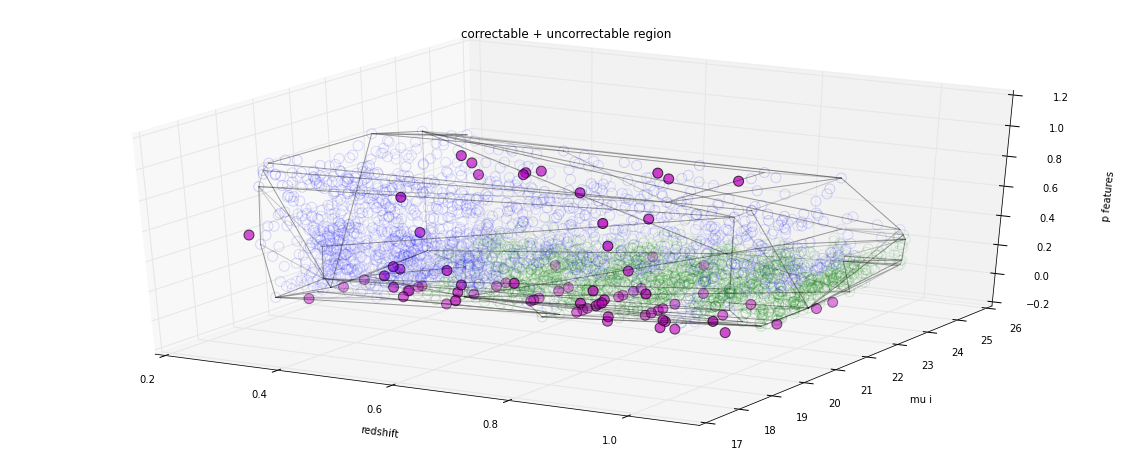

In [10]:
#First define a hull to encompass all non-nei galaxies: 
#Anything outside this hull in Hubble will be not be corrected 
#Anything inside this hull in Hubble will either be correctable or uncorrectable
all_points=not_nei_array.T
all_hull=ConvexHull(all_points)

#Just uncorrectable:
un_points=uncorrectable_array.T
hull=ConvexHull(un_points)

#3D plot of hull 
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.2,s=100,label='correctable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none',edgecolors='g',alpha=.2,s=100,label='uncorrectable')
ax.scatter(nei_array[0], nei_array[1], nei_array[2],facecolors='m',alpha=.8,s=100,label='nei')

for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'k-',alpha=.2)
ax.set_xlabel('redshift')
ax.set_ylabel('mu i')
ax.set_zlabel('p features')
plt.title('correctable + uncorrectable region')

In [11]:
#function to determine whether a point 'p' is inside convex hull defined by points 'points'. 
def is_p_inside_hull(points,p):
    hull=ConvexHull(points)
    new_points=np.concatenate((points,p),axis=0)
    new_hull=ConvexHull(new_points)
    if list(hull.vertices)==list(new_hull.vertices):
        return True
    else:
        return False



In [12]:
#Function to count how many points are in hull:

def number_of_points_in_hull(this_array,hull_array):
    n_in_hull=0
    for row in this_array:
        this_point = np.array([row])
        if is_p_inside_hull(hull_array,this_point)==True:
            n_in_hull+=1
    return n_in_hull

In [13]:
#Function to remove points from uncorrectable hull until there is minimal overlap between the two regions
def new_convex_hull(total_points_to_remove,points_at_a_time):
    #This is the original array. 
    un_points=uncorrectable_array.T
    hull=ConvexHull(un_points)

    #first find the center of the 3D data: 
    z_center=np.median(un_points[:,0])
    mu_center=np.median(un_points[:,1])
    p_center=np.median(un_points[:,2])

    #now figure out distance to center for each point:
    distance_to_center=[]
    for row in un_points:
        distance_to_center.append(np.sqrt((row[0]-z_center)**2+(row[1]-mu_center)**2+(row[2]-p_center)**2))
    un_points=np.insert(un_points,3,distance_to_center,axis=1)


    #Eliminate the point farthest from the center, repeat until things are cool 

    #start by sorting array by distance from center 
    new_un_array=un_points[np.argsort(un_points[:,3])]
    #now delete that column because convexhull hates it
    new_un_array=np.delete(new_un_array,3,axis=1)


    #Now loop - eliminate point by point, recalculate hull, then check the ratio of correctable:uncorrectable points. Find the minimum. 
    i_list=[]
    blue_outside_hull_fraction=[]
    green_inside_hull_fraction=[]
    N=len(new_un_array) # number of points in original hull 
    for i in range(0,total_points_to_remove/points_at_a_time):
        #delete furthest point from center
        for j in range(0,points_at_a_time):
            new_un_array=np.delete(new_un_array,len(new_un_array)-1,0)
        #new_un_array is the new uncorrectable points considered for hull
        #new hull with furthest point removed
        new_hull=ConvexHull(new_un_array)
        #now we want to know how many points are in new hull (uncorrectable + correctable)
        #number of green in hull is just the length of new_un_array
        #number of blue in hull:
        N_blue_in_hull = number_of_points_in_hull(correctable_array.T,new_un_array)
        N_in_hull = len(new_un_array) + N_blue_in_hull
        #fraction of points in hull that are green:
        green_frac_in_hull = float(len(new_un_array))/N_in_hull
        #now want fraction of blue points outside of hull:
        #total number of points outside hull:
        total_outside_hull = len(correctable_array.T)+len(uncorrectable_array.T) - len(new_un_array)
        N_blue_outside_hull = len(correctable_array.T) - N_blue_in_hull
        blue_frac_outside_hull = float(N_blue_outside_hull)/total_outside_hull
        #track how many correctable and uncorrectable points are in hull with each iteration: 
        i_list.append(points_at_a_time*i)
        green_inside_hull_fraction.append(green_frac_in_hull)
        blue_outside_hull_fraction.append(blue_frac_outside_hull)
    return i_list,blue_outside_hull_fraction,green_inside_hull_fraction,new_hull,new_un_array


In [14]:
#Try removing a 200 points, 10 at a time:
i_list,co_fraction,un_fraction,new_hull,new_un_array=new_convex_hull(400,10)


points to remove for highest purity in correctible region is 0


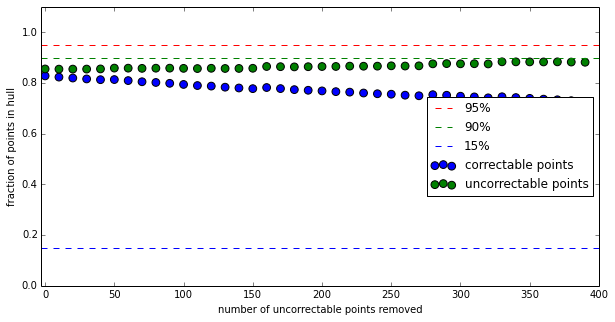

In [15]:
f=plt.figure(figsize=(10,5))
plt.scatter(i_list,co_fraction,label='correctable points',s=60)
plt.scatter(i_list,un_fraction,label='uncorrectable points',s=60,c='g')
plt.xlabel('number of uncorrectable points removed')
plt.ylabel('fraction of points in hull') 
plt.axhline(y=0.95,ls='dashed',label='95%',c='r')
plt.axhline(y=0.9,ls='dashed',label='90%',c='g')
plt.axhline(y=0.15,ls='dashed',label='15%',c='b')
plt.legend(loc='center right')
plt.ylim(0,1.1)
plt.xlim(-3,400)

max_frac=np.max(co_fraction)
for i,val in enumerate(co_fraction):
    if val==max_frac:
        max_points=i*10
print 'points to remove for highest purity in correctible region is %i'%max_points

In [16]:
max_points

0

In [17]:
#Based on above plot, determine how many points are appropriate to cut from hull to make final version:
N_to_cut=max_points+1
i_list,co_fraction,un_fraction,new_hull,new_un_array=new_convex_hull(N_to_cut,1)
print 'By excluding %s of %s uncorrectable galaxies when computing the uncorrectable hull region, the correctable region consists of %s%% correctable galaxies and the uncorrectable region consists of %s%% of uncorrectable galaxies.' %(N_to_cut,len(uncorrectable_array.T),round(np.max(co_fraction)*100,2),round(np.max(un_fraction)*100,2)
)

By excluding 1 of 1678 uncorrectable galaxies when computing the uncorrectable hull region, the correctable region consists of 83.21% correctable galaxies and the uncorrectable region consists of 85.56% of uncorrectable galaxies.


# don't need to adjust hull this run; contamination already minimized

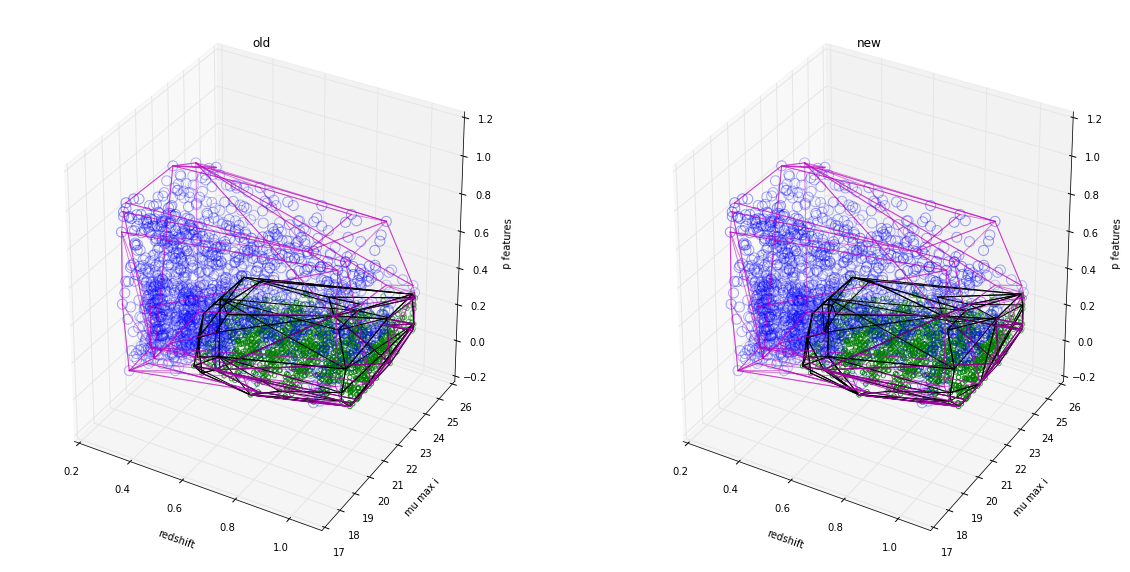

In [18]:
#3D plot of old hull 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.5,s=100,label='correctable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none', edgecolors='g',label='uncorrectable')
for s in hull.simplices:
	ax.plot(un_points[s,0],un_points[s,1],un_points[s,2],'k-')
for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'m-',alpha=.5)

#ax.scatter(nei_array[0], nei_array[1], nei_array[2], facecolors='none',edgecolors='m',label='nei')
ax.set_xlabel('redshift')
ax.set_ylabel('mu max i')
ax.set_zlabel('p features')
plt.title('old')

#3D plot of new hull  
ax = fig.add_subplot(122, projection='3d')
ax.scatter(correctable_array[0], correctable_array[1], correctable_array[2], facecolors='none',edgecolors='b',alpha=.5,s=100,label='correctable')
#ax.scatter(new_un_array[:,0], new_un_array[:,1], new_un_array[:,2], facecolors='none', edgecolors='g',label='uncorrectable')
ax.scatter(uncorrectable_array[0], uncorrectable_array[1], uncorrectable_array[2], facecolors='none', edgecolors='g',label='uncorrectable')
for s in new_hull.simplices:
	ax.plot(new_un_array[s,0],new_un_array[s,1],new_un_array[s,2],'k-')
for s in all_hull.simplices:
	ax.plot(all_points[s,0],all_points[s,1],all_points[s,2],'m-',alpha=.5)
#ax.scatter(nei_array[0], nei_array[1], nei_array[2], facecolors='none',edgecolors='m',label='nei')
ax.set_xlabel('redshift')
ax.set_ylabel('mu max i')
ax.set_zlabel('p features')
plt.title('new')
#plt.savefig('3D_hull.pdf')
plt.show()

In [19]:
#Okay, we have a convex hull that defines the uncorrectable region pretty well. 
#Anything outside pink = nei
#Anything inside pink but outside black = correctable
#Anything inside black = uncorrectable 

# Input - Hubble data
## Use redshift, SB and p_features info to categorize Hubble data. 

In [22]:
hubble_data_file=download_from_dropbox("https://www.dropbox.com/s/b55kbq49ep21qow/gzh_t01_mu.fits?dl=1")
hubble_data=pyfits.open(hubble_data_file)
hubble_data=hubble_data[1].data

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [23]:
#make new table with extra column of the new categories based on hull
#have to make a whole new table because python doesn't recognize bintablehdu.from_columns for some reason and I'm sick of dealing with it

#first redefine old table:
new_category_table=Table()
for name in hubble_data.columns.names:
    c0 = Column([x[name] for x in hubble_data], name=name) 
    new_category_table.add_columns([c0])
c1 = Column([x['zooniverse_id'] for x in hubble_data],name='Correctable_Category')
c2 = Column([x['Z_BEST'] for x in hubble_data],name='correction_type')

new_category_table.add_columns([c1,c2])

In [24]:
#now determine new category for each point based on hull
z = 'Z_BEST'
p_features = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction'
for r,row in enumerate(new_category_table):
    this_point = np.array([[row[z],row[SB],row[p_features]]])

    if row[z] < 0.3 and row[z] > 0: #redshift less than 0.3, not getting corrected
        row['Correctable_Category']='z_lt_3'
        row['correction_type']=2
    elif row[z] <= 0 or row[z] > 9 or str(row[z])=='nan': #galaxy doesn't have redshift info
        row['Correctable_Category']='nei_needs_redshift'
        row['correction_type']=4

    elif row[SB]<0: #galaxy doesn't have surface brightness measurement
        row['Correctable_Category']='nei'
        row['correction_type']=3

    #if galaxy is in the all_hull, check if correctable or un. Else, is nei.:
    elif is_p_inside_hull(all_points,this_point) == True:
            if is_p_inside_hull(uncorrectable_array.T,this_point)==True:
                row['Correctable_Category']='uncorrectable'
                row['correction_type']=1

            else: #in all_hull, but not in uncorrectable, therefore correctable
                row['Correctable_Category']='correctable'
                row['correction_type']=0

    else: #not nei_needs_redshift, not z < .3, and not in all_hull - just nei. 
        row['Correctable_Category']='nei'
        row['correction_type']=3



# Output 
## Same info as input table, but additional column 'Correctable_Category' containing the categorization. Used in STEP 4 - writing the catalog to determine p_features_best 

In [35]:
#Set path for output
fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/gzh_t01_z_mu_categorized.fits'

if os.path.exists(fname):
    os.remove(fname)
new_category_table.write(fname,format='fits')

In [29]:
print 'Correctable = %i'%(len(new_category_table[new_category_table['correction_type']==0]))
print 'Uncorrectable = %i'%(len(new_category_table[new_category_table['correction_type']==1]))
print 'lt3 = %i'%(len(new_category_table[new_category_table['correction_type']==2]))
print 'nei = %i'%(len(new_category_table[new_category_table['correction_type']==3]))
print 'nei_nr = %i'%(len(new_category_table[new_category_table['correction_type']==4]))

Correctable = 33656
Uncorrectable = 11801
lt3 = 15401
nei = 59089
nei_nr = 7756


In [30]:
len(new_category_table)

127703